In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from preprocessing_soil import prepare_data
from soil import fill_thermal_conductivity

In [2]:
# read data
df_flux_fbg = pd.read_csv("data_2024/EddyCovarianceData/eng/FBG_fluxes_30min_20240401_20240608_eng.csv")
df_flux_goew = pd.read_csv("data_2024/EddyCovarianceData/eng/GoeW_fluxes_30min_20240401_20240608_eng.csv")
df_meteo_fbg = pd.read_csv("data_2024/MeteorologicalData/eng/FBG_meteo_30min_20240401_20240608_eng.csv")
df_meteo_goew = pd.read_csv("data_2024/MeteorologicalData/eng/GoeW_meteo_30min_20240401_20240608_eng.csv")

Check if data formats are consistent for fbg and goew

In [3]:
print(df_flux_fbg.info())
print(df_flux_goew.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3264 entries, 0 to 3263
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   TIMESTAMP_START  3264 non-null   object
 1   TIMESTAMP_MID    3264 non-null   object
 2   TIMESTAMP_END    3264 non-null   object
 3   H_orig           1821 non-null   object
 4   H_f              3264 non-null   object
 5   LE_orig          1750 non-null   object
 6   LE_f             3264 non-null   object
 7   ET_orig          1750 non-null   object
 8   ET_f             3264 non-null   object
 9   CO2              1702 non-null   object
 10  H2O              1712 non-null   object
 11  NEE_orig         1713 non-null   object
 12  NEE_f            3264 non-null   object
 13  Reco             3264 non-null   object
 14  GPP_f            3264 non-null   object
 15  Ustar            3262 non-null   object
dtypes: object(16)
memory usage: 408.1+ KB
None
<class 'pandas.core.frame.DataFrame

The meteo data seems perfectly consistent.

In [4]:
print(df_meteo_fbg.info())
print(df_meteo_goew.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3265 entries, 0 to 3264
Data columns (total 26 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   TIMESTAMP_START                   3265 non-null   object
 1   TIMESTAMP_MID                     3265 non-null   object
 2   TIMESTAMP_END                     3265 non-null   object
 3   incomingShortwaveRadiation_300cm  3265 non-null   object
 4   outgoingShortwaveRadiation_300cm  3265 non-null   object
 5   netRadiation_300cm                3265 non-null   object
 6   incomingPPFD_300cm                3265 non-null   object
 7   outgoingPPFD_300cm                3265 non-null   object
 8   soilHeatFlux                      3265 non-null   object
 9   airPressure                       3265 non-null   object
 10  airTemperature_40cm               3265 non-null   object
 11  airTemperature_200cm              3265 non-null   object
 12  relHumidity_40cm    

The meteo data is a bit different for FBG and Goew. Specifically:
- The Goew FBG data does not contain longwave radiation. This is not a problem since we only need the net radiation.
- For the FBG data, the soil heat flux is missing. Instead, the soil moisture and temperature are measured at different heights which can be used to calculate the soil heat flux.

Overall it seems like all the data that is needed to calculate the Energy Balance Closure is there.

In [5]:
# relevant columns
cols_meteo_fbg = ["netRadiation_300cm", "soilHeatFlux"]
cols_meteo_goew = ["incomingLongwaveRadiation_43m", "incomingShortwaveRadiation_43m", "outgoingLongwaveRadiation_43m", 
                   "outgoingShortwaveRadiation_43m"] \
                    + [f"soilMoisture_{idx}_{depth}cm" for idx in [1, 2, 3] for depth in [5, 15, 30]]\
                    +[f"soilTemperature_{idx}_{depth}cm" for idx in [1, 2, 3] for depth in [5, 15, 30]]

cols_fluxes = ["H_f", "H_orig", "LE_f", "NEE_f"]

# prepare data
df_flux_fbg, df_flux_goew, df_meteo_fbg, df_meteo_goew = prepare_data(df_flux_fbg, df_flux_goew, df_meteo_fbg,
                                                                      df_meteo_goew, cols_fluxes, cols_meteo_fbg, cols_meteo_goew, "TIMESTAMP_START", fill_gaps=False)
# TODO: fill missing values

# Investigate the gaps
## Flux data

In [6]:
# Specify the column of interest
column_of_interest = 'H_orig'

# Create a boolean series where True indicates NaN
nan_series = df_flux_fbg[column_of_interest].isna()



# Calculate the maximum number of consecutive NaNs
max_consecutive_nans = nan_series.astype(int).groupby(nan_series.ne(nan_series.shift()).cumsum()).cumsum().max()

print(f"The maximum number of consecutive NaN values in column '{column_of_interest}' is: {max_consecutive_nans}")

The maximum number of consecutive NaN values in column 'H_orig' is: 39


In [7]:
df_flux_fbg.shape

(3263, 18)

In [8]:
nan_series[nan_series].shape

(1443,)

## Meteo data

In [9]:
# analyse gaps

def get_biggest_gaps(col):
    # Create a boolean series where True indicates NaN
    nan_series = df_meteo_goew[col].isna()



    # Calculate the maximum number of consecutive NaNs
    max_consecutive_nans = nan_series.astype(int).groupby(nan_series.ne(nan_series.shift()).cumsum()).cumsum().max()

    print(f"The maximum number of consecutive NaN values in column '{col}' is: {max_consecutive_nans}")

for col in cols_meteo_goew:
    get_biggest_gaps(col)


The maximum number of consecutive NaN values in column 'incomingLongwaveRadiation_43m' is: 1
The maximum number of consecutive NaN values in column 'incomingShortwaveRadiation_43m' is: 1
The maximum number of consecutive NaN values in column 'outgoingLongwaveRadiation_43m' is: 1
The maximum number of consecutive NaN values in column 'outgoingShortwaveRadiation_43m' is: 1
The maximum number of consecutive NaN values in column 'soilMoisture_1_5cm' is: 6
The maximum number of consecutive NaN values in column 'soilMoisture_1_15cm' is: 6
The maximum number of consecutive NaN values in column 'soilMoisture_1_30cm' is: 6
The maximum number of consecutive NaN values in column 'soilMoisture_2_5cm' is: 6
The maximum number of consecutive NaN values in column 'soilMoisture_2_15cm' is: 6
The maximum number of consecutive NaN values in column 'soilMoisture_2_30cm' is: 6
The maximum number of consecutive NaN values in column 'soilMoisture_3_5cm' is: 6
The maximum number of consecutive NaN values in 

In [10]:
df_meteo_goew[df_meteo_goew["soilMoisture_1_15cm"].isna()]

,TIMESTAMP_START,TIMESTAMP_MID,TIMESTAMP_END,incomingShortwaveRadiation_43m,outgoingShortwaveRadiation_43m,incomingLongwaveRadiation_43m,outgoingLongwaveRadiation_43m,airPressure_43m,airTemperature_2m,airTemperature_43m,...,soilMoisture_2_5cm,soilMoisture_3_5cm,soilMoisture_1_15cm,soilMoisture_2_15cm,soilMoisture_3_15cm,soilMoisture_1_30cm,soilMoisture_2_30cm,soilMoisture_3_30cm,date,time
266,2024-04-06 12:30:00,2024-04-06 12:45:00,2024-04-06 13:00:00,787.133333,99.166667,333.320201,433.598534,959.0,NaN,20.080000000000002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-04-06,12:30:00
267,2024-04-06 13:00:00,2024-04-06 13:15:00,2024-04-06 13:30:00,716.233333,88.033333,328.229911,435.817911,959.0,NaN,21.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-04-06,13:00:00
268,2024-04-06 13:30:00,2024-04-06 13:45:00,2024-04-06 14:00:00,687.066667,82.100000,324.847470,437.391137,958.0,NaN,21.52333333333333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-04-06,13:30:00
269,2024-04-06 14:00:00,2024-04-06 14:15:00,2024-04-06 14:30:00,436.633333,50.850000,337.694936,433.693936,958.0,NaN,21.953333333333333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-04-06,14:00:00
270,2024-04-06 14:30:00,2024-04-06 14:45:00,2024-04-06 15:00:00,403.766667,48.400000,339.805145,431.325479,958.0,NaN,21.926666666666666,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-04-06,14:30:00
271,2024-04-06 15:00:00,2024-04-06 15:15:00,2024-04-06 15:30:00,511.600000,59.456667,332.129631,435.904964,958.0,NaN,22.50666666666667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-04-06,15:00:00
359,2024-04-08 11:00:00,2024-04-08 11:15:00,2024-04-08 11:30:00,677.833333,86.266667,331.411960,431.217626,954.3333333333334,NaN,20.41,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-04-08,11:00:00


In [11]:
# check that data covers the same dates
print(df_meteo_fbg["date"].min())
print(df_meteo_goew["date"].max())
print(df_flux_fbg["date"].min())
print(df_flux_goew["date"].max())

2024-04-01 00:00:00
2024-06-07 00:00:00
2024-04-01 00:00:00
2024-06-07 00:00:00


<Axes: >

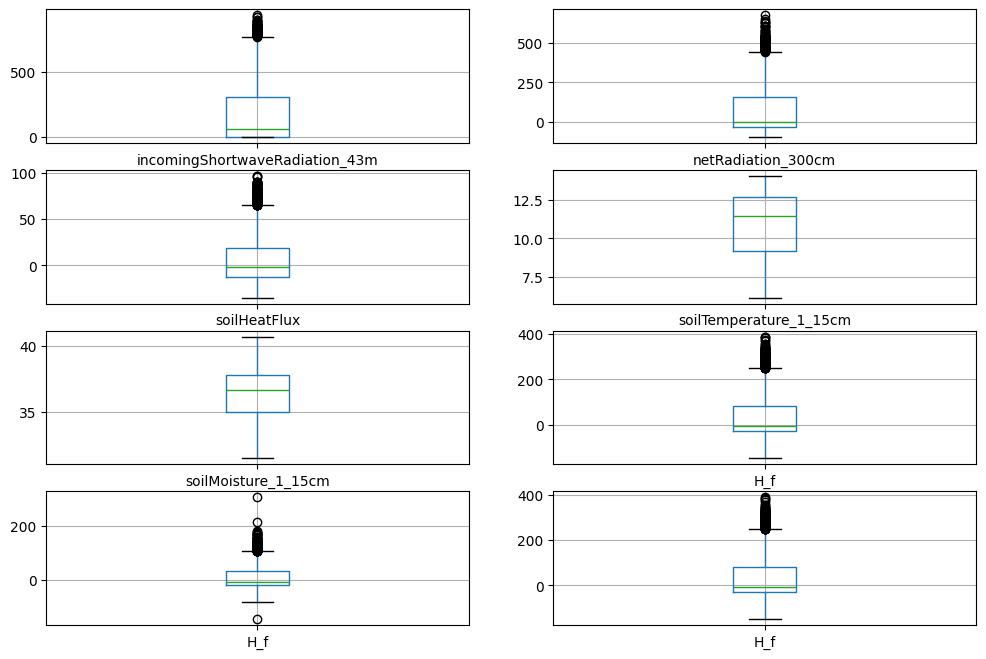

In [12]:
fig, axs = plt.subplots(4, 2, figsize=(12,8))
# check for outliers
df_meteo_goew.boxplot(column="incomingShortwaveRadiation_43m", ax=axs[0, 0])
df_meteo_fbg.boxplot(column="netRadiation_300cm", ax=axs[0, 1])
df_meteo_fbg.boxplot(column="soilHeatFlux", ax = axs[1, 0])
df_meteo_goew.boxplot(column="soilTemperature_1_15cm", ax=axs[1, 1])
df_meteo_goew.boxplot(column="soilMoisture_1_15cm", ax=axs[2, 0])
df_flux_goew.boxplot(column="H_f", ax=axs[2, 1])
df_flux_fbg.boxplot(column="H_f", ax=axs[3, 0])
df_flux_goew.boxplot(column="H_f", ax=axs[3, 1])




In [13]:
# get diurnal cylces
def diurnal_cycles_goew(df_fluxes, df_meteo):
    # calculate net radiation
    df_meteo["Q"] = df_meteo["incomingShortwaveRadiation_43m"] + df_meteo["outgoingShortwaveRadiation_43m"]    
    df_fluxes_agg = df_fluxes.groupby("time").agg(H=("H_f", "mean"), LE=("LE_f", "mean"))
    df_meteo_agg = df_meteo.groupby("time").agg(Q=("Q", "mean"))
    df_joined = df_fluxes_agg.merge(df_meteo_agg, on="time")
    df_joined["H+LE"] = df_joined["H"] + df_joined["LE"] 
    return df_joined


def diurnal_cycles_fbg(df_fluxes, df_meteo):
    df_fluxes_agg = df_fluxes.groupby("time").agg(H=("H_f", "mean"), LE=("LE_f", "mean"))
    df_meteo["Q"] = df_meteo["netRadiation_300cm"].astype(float)
    df_meteo["G"] = df_meteo["soilHeatFlux"].astype(float)
    df_meteo_agg = df_meteo.groupby("time").agg(Q=("Q", "mean"), G=("G", "mean"))
    df_joined = df_fluxes_agg.merge(df_meteo_agg, on="time")
    df_joined["H+G+LE"] = df_joined["H"] + df_joined["G"] + df_joined["LE"] 
    df_joined["res"] = df_joined["Q"] - df_joined["H+G+LE"]
    return df_joined



df_goew = diurnal_cycles_goew(df_flux_goew, df_meteo_goew)
df_fbg = diurnal_cycles_fbg(df_flux_fbg, df_meteo_fbg)

<Axes: xlabel='time'>

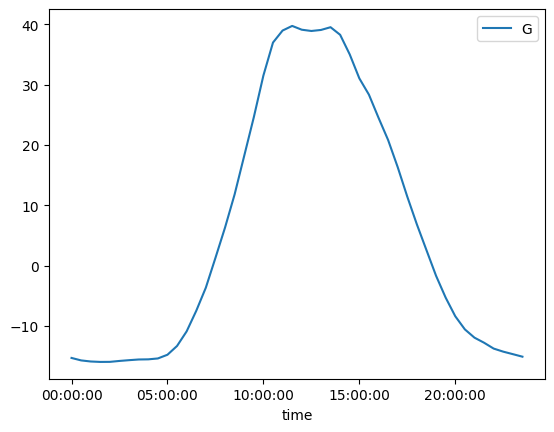

In [14]:
#df_fbg[["Q", "H+G+LE", "G", "res"]].plot()
df_fbg[["G"]].plot()

<Axes: xlabel='time'>

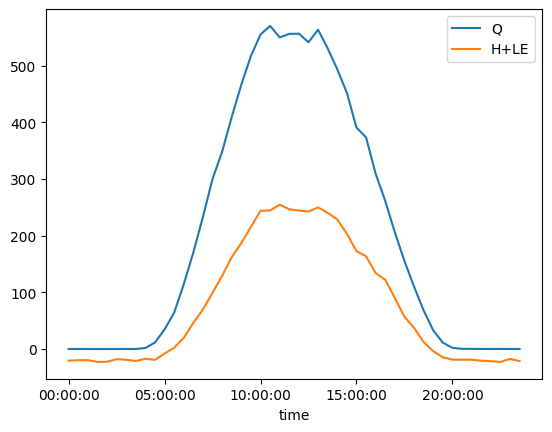

In [15]:
df_goew[["Q", "H+LE"]].plot()

# Soil temperature and moisture

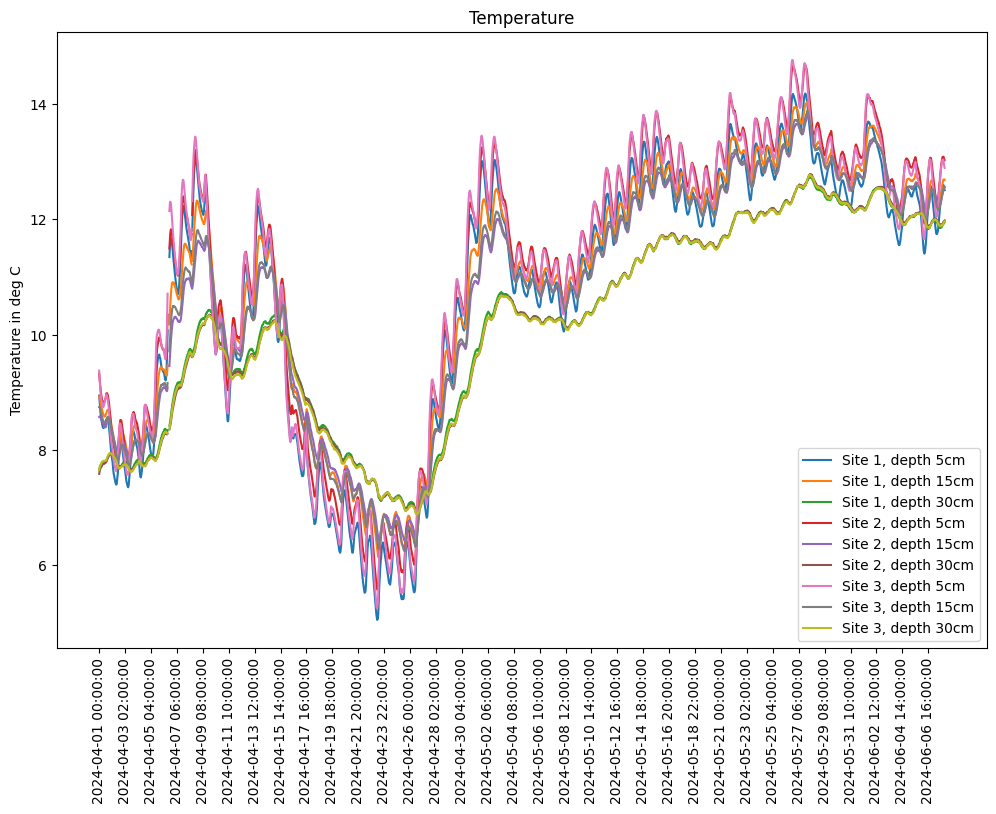

In [16]:
measure_indices = [1, 2, 3]
depths = [5, 15, 30]

plt.figure(figsize=(12, 8))
plt.title("Temperature")
for i, idx in zip(range(len(measure_indices)), measure_indices):
    for j, depth in zip(range(len(depths)), depths):
        plt.plot(df_meteo_goew["TIMESTAMP_START"], df_meteo_goew[f"soilTemperature_{idx}_{depth}cm"], label=f"Site {idx}, depth {depth}cm")
plt.xticks(df_meteo_goew["TIMESTAMP_START"].unique()[::100], rotation=90)
plt.ylabel("Temperature in deg C")
plt.legend()
plt.show()

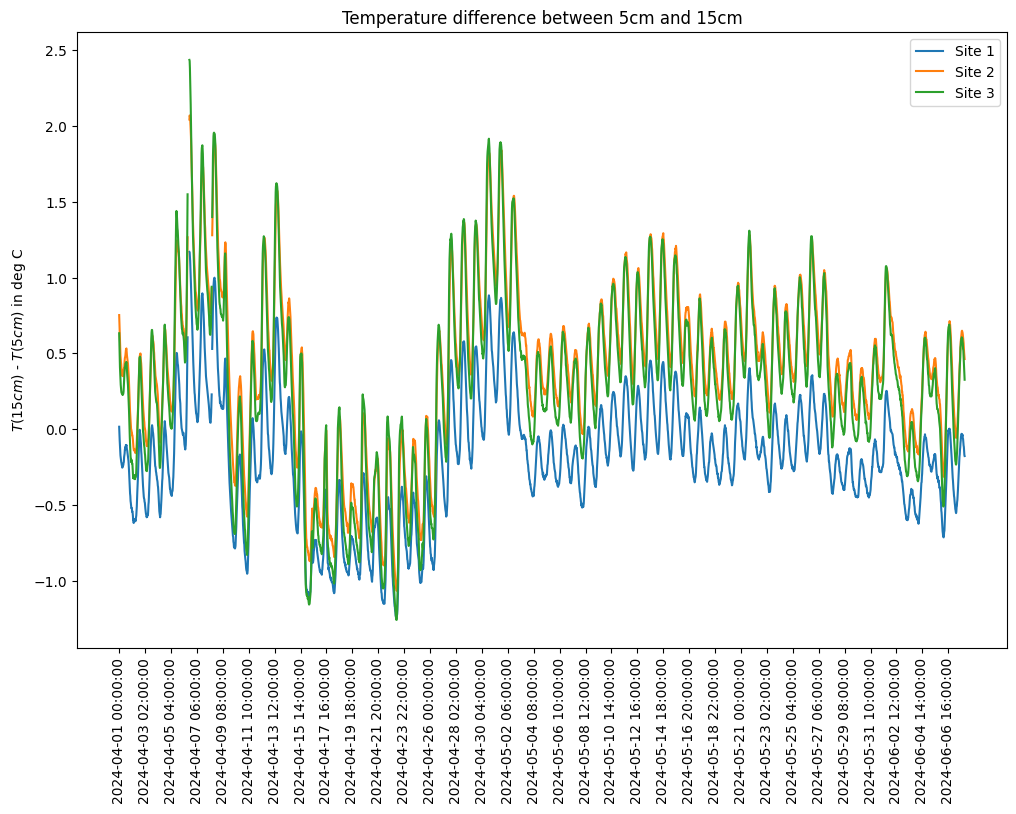

In [17]:
plt.figure(figsize=(12, 8))
plt.title("Temperature difference between 5cm and 15cm")
for i, idx in zip(range(len(measure_indices)), measure_indices):
        plt.plot(df_meteo_goew["TIMESTAMP_START"], df_meteo_goew[f"soilTemperature_{idx}_5cm"] - df_meteo_goew[f"soilTemperature_{idx}_15cm"], label=f"Site {idx}")
plt.xticks(df_meteo_goew["TIMESTAMP_START"].unique()[::100], rotation=90)
plt.ylabel("$T(15cm)$ - $T(5cm)$ in deg C")
plt.legend()
plt.show()

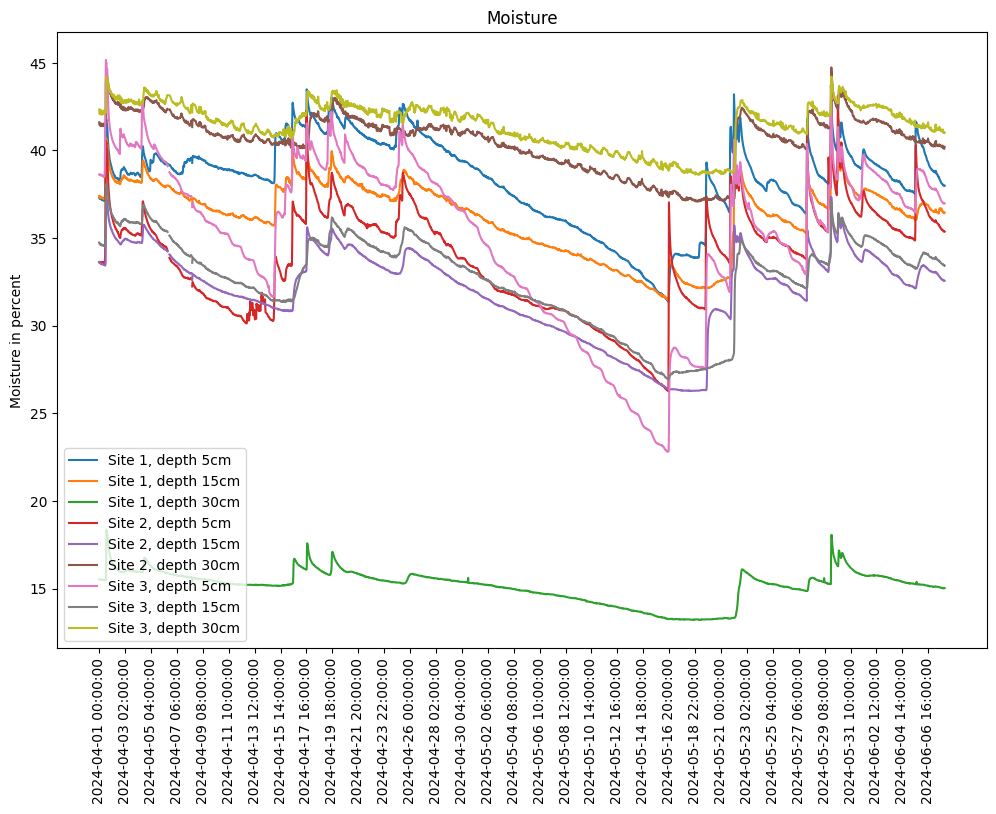

In [18]:
plt.figure(figsize=(12, 8))
plt.title("Moisture")
for i, idx in zip(range(len(measure_indices)), measure_indices):
    for j, depth in zip(range(len(depths)), depths):
        plt.plot(df_meteo_goew["TIMESTAMP_START"], df_meteo_goew[f"soilMoisture_{idx}_{depth}cm"], label=f"Site {idx}, depth {depth}cm")
plt.xticks(df_meteo_goew["TIMESTAMP_START"].unique()[::100], rotation=90)
plt.ylabel("Moisture in percent")
plt.legend()
plt.show()

The moisture for site 1 at 30cm depth is kinda sus ...

# Thermal conductivity
Check for consistency with literature first (De Vries Model).

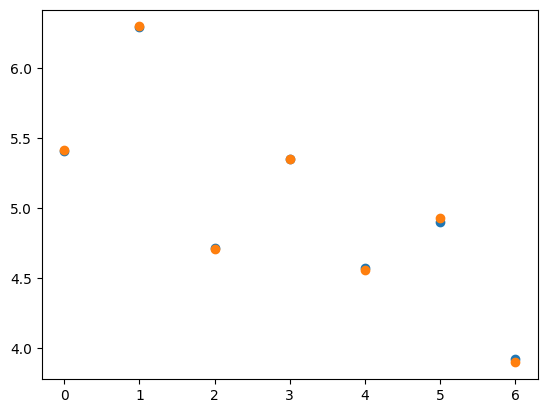

In [19]:
import numpy as np


# some calculations to compare thermal conductivity to literature values

def get_thermal_conductivity(x_water, x_soil, x_quartz, x_other, x_air, k_water, k_quartz, k_other, k_air, n):
    """Compute thermal conductivity according to De Vries model:
    DeVries D.A. (1963) Thermal Properties of Soils. In W.R. van Wijk (ed.) Physics of Plant Environment. North-Holland Publishing Company, Amsterdam.

    Original paper not available anywhere so see e.g. the following:
    https://www.sciencedirect.com/science/article/pii/0165232X81900410

    Args:
        water_content (_type_): _description_
    """
    # weighting factor for quartz
    F_quartz = 1 / 3 * (2 / (1+ 0.125 * (k_quartz / k_water - 1)) + 1 / (1+ 0.75 * (k_quartz / k_water - 1)))
    # weighting factor for other materials
    F_other = 1 / 3 * (2 / (1+ 0.125 * (k_other / k_water - 1)) + 1 / (1+ 0.75 * (k_other / k_water - 1)))

    # weighting factor for air
    if x_water > 0.09:
        ga = 0.333 - x_air / n * (0.333 - 0.035) # found conflicting info, best double check 
    else:
        ga = 0.013 + 0.944 * x_water
    gc = 1 - 2 * ga
    F_air = 1 / 3 * (2 / (1+ ga * (k_air / k_water - 1)) + 1 / (1+ gc * (k_air / k_water - 1)))
    
    # compute thermal conductivity
    k = (k_water * x_water + F_air * k_air * x_air + F_quartz * k_quartz * x_quartz + F_other * k_other * x_other) / (x_water  + F_air * x_air + F_quartz * x_quartz + F_other * x_other)
    return k


# de vries values for thermal conductivities of components
k_water = 1.34
k_quartz = 21.6 
k_other = 7.0 
k_air = 0.059 + 0.066



# example data from p. 231, Table 7.5 in De Vries
x_water = np.array([0.212, 0.203, 0.184, 0.117, 0.112, 0.102, 0.101])
x_soil = np.array([0.660, 0.710, 0.632, 0.705, 0.665, 0.691, 0.631])
x_air = np.array([0.128, 0.087, 0.184, 0.178, 0.223, 0.207, 0.268])

# their values
lam_lit = np.array([5.42, 6.30, 4.71, 5.35, 4.56, 4.93, 3.90])
# our values
lam_calc = []



for x_w, x_s, x_a in zip(x_water, x_soil, x_air):
    x_quartz = 0.606 * x_s
    x_other = (1- 0.606) * x_s
    lam = get_thermal_conductivity(x_w, x_s, x_quartz, x_other, x_a, k_water, k_quartz, k_other, k_air, n = 1 - x_s)
    lam_calc.append(lam)


plt.scatter(range(len(lam_calc)), lam_calc)
plt.scatter(range(len(lam_lit)), lam_lit)

It looks pretty consistent, so the implementation should be correct.

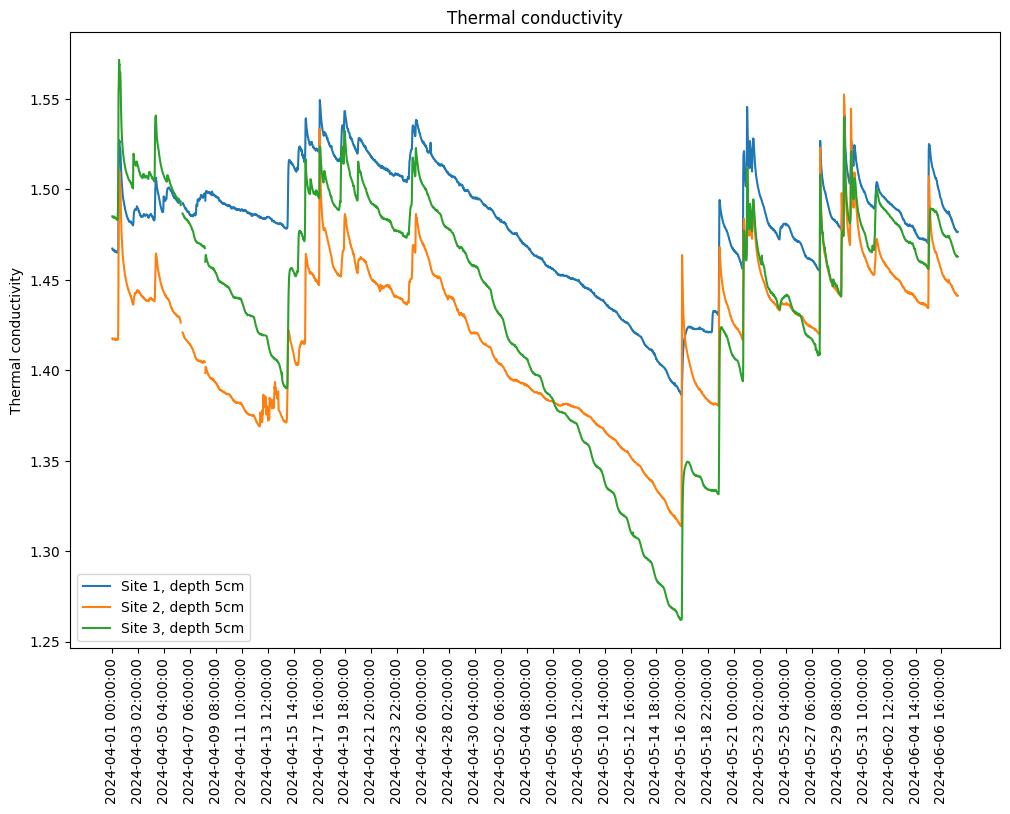

In [24]:
# compute thermal conductivity 
df_meteo_goew = fill_thermal_conductivity(df_meteo_goew)
plt.figure(figsize=(12, 8))
plt.title("Thermal conductivity")
for i, idx in zip(range(len(measure_indices)), measure_indices):
    plt.plot(df_meteo_goew["TIMESTAMP_START"], df_meteo_goew[f"thermalConductivity_{idx}_5cm"], label=f"Site {idx}, depth 5cm")
plt.xticks(df_meteo_goew["TIMESTAMP_START"].unique()[::100], rotation=90)
plt.ylabel("Thermal conductivity")
plt.legend()
plt.show()